In [1]:
# This cell provides the capability to produce interactive plots
%matplotlib ipympl

import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

# Shallow water: a geostrophically balanced test case

This notebook provides an introduction to Gusto. We will demonstrate how to set up and run a shallow water model using the geostrophic balance example (test case 2) from [Williamson et. al. (1992)](https://doi.org/10.1016/S0021-9991(05)80016-6).

The shallow water equations are written in terms of the 2D velocity, $\textbf{u}$, and fluid depth, $D$:

\begin{align}
\textbf{u}_t + (\textbf{u} \cdot \nabla) \textbf{u} + f \textbf{u}^{\perp} + g \nabla (D + b)  &= 0, \\
D_t + \nabla \cdot (D \textbf{u}) &= 0,
\end{align}

where $f$ is the Coriolis parameter, $g$ is the gravitational acceleration, and $D = H+h-b$ is the total depth of the fluid where $H$ is the mean fluid depth, $h$ is the free surface height and $b$ is the topography. No boundary conditions are required as in this case we are solving on a spherical domain.

The problem we shall set up is a zonal geostrophic flow. This is a steady-state solution of the shallow-water equations, so the true solution does not change with time.

We begin by importing the required libraries and functions from Firedrake and Gusto. This step is required when starting any Gusto script.

In [2]:
from gusto import *
from firedrake import SpatialCoordinate, as_vector, pi, sin, cos, triplot, trisurf

INFO     Running /Users/JS1075/firedrake_dec24/lib/python3.12/site-packages/ipykernel_launcher.py -f /private/var/folders/f0/llvlmlb50qg6mmlxs8m6d6d00000gp/T/tmp4fe9d8sj.json --HistoryManager.hist_file=:memory:


First, we construct a mesh of our domain. We will use one of the spherical meshes provided by Gusto, the `GeneralCubedSphereMesh`, which generates a mesh of the sphere by transforming a mesh of a cube. As the spherical domain we are solving over is the Earth we specify the radius as 6371220m. The argument `num_cells_per_edge_of_panel`, specifies the number of cells along each edge of each face of the cube. The argument `degree` specifies the polynomial degree of the function space used to represent the coordinates; we use `degree=2` so that we can represent the curvature of the sphere.

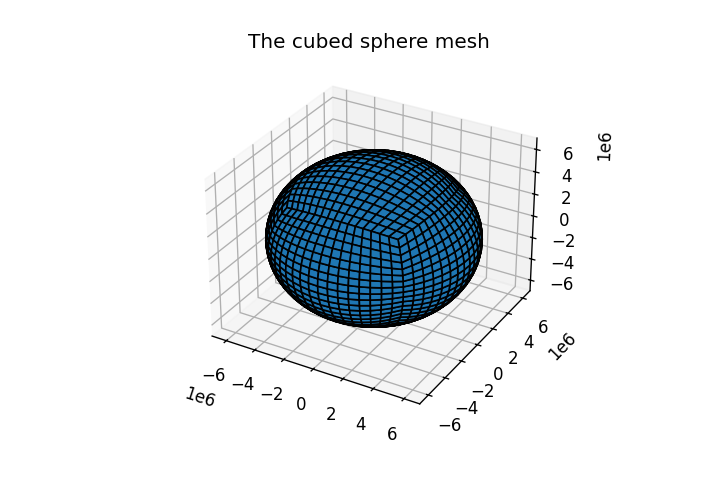

In [3]:
R = 6371220.
mesh = GeneralCubedSphereMesh(radius=R, num_cells_per_edge_of_panel=16, degree=2)

# These commands produce the figure below
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title('The cubed sphere mesh')
ts = triplot(mesh, axes=ax)
plt.show()

Gusto will set up compatible finite element function spaces for the prognostic fields. These are uniquely defined by specifying the family (in this case `RTCF`) of the HDiv space (used for the velocity $\textbf{u}$) and the degree (in this case `1`) of the DG space (used for the fluid depth $D$). We pass these parameters, along with the mesh and the timestep, `dt=900`s, into the `Domain` object. For further information on these finite element function spaces, see [Cotter 2023](https://doi.org/10.1017/S0962492923000028).

In [4]:
dt = 900.
domain = Domain(mesh, dt, family="RTCF", degree=1)

The shallow water equations contain three parameters that need to be specified: the gravitational acceleration $g$, the mean height of the fluid layer $H$ and the Coriolis parameter $f=2\Omega\sin\theta$ where $\Omega$ is the rotation rate and $\theta$ the latitude. The `ShallowWaterParameters` class has Earth-sized values as default for both $\Omega$ (`=7.292e-5`rad/s) and $g$ (`=9.80616`m/s$^2$) meaning that for this example we only need to specify $H$. We also pass the mesh to the `ShallowWaterParameters` object.

In [5]:
parameters = ShallowWaterParameters(mesh, H=5960.)

We can now set up the finite element form of the shallow water equations by passing `domain`, `parameters` and the expression for the Coriolis parameter into the `ShallowWaterEquations` class. To construct the Coriolis expression, `fexpr`, we need the latitude $\theta$ (computed from the coordinates `xyz` of the mesh) and the $\Omega$ value from the `parameters` instance.

In [6]:
Omega = parameters.Omega
xyz = SpatialCoordinate(mesh)
lon, lat, _ = lonlatr_from_xyz(*xyz)  # we also need the longitude later
fexpr = 2*Omega*sin(lat)
eqns = ShallowWaterEquations(domain, parameters, fexpr=fexpr)

We specify output options using the `OutputParameters` class. The directory name, `dirname`, must be specified. To prevent losing hard-earned simulation data, Gusto will not allow existing files to be overwritten. Hence, if one wishes to re-run a simulation with the same output filename, the existing results directory needs to be moved or deleted first. This is also the place to specify the output frequency (in timesteps). The default is `dumpfreq=1` which outputs at every timestep (very useful when first setting up a problem!). Below we set `dumpfreq=5`. The default output file format is `vtu`, which can be opened in [Paraview](https://www.paraview.org).

In [7]:
output = OutputParameters(dirname="williamson_2", dumpfreq=5)

We can specify which diagnostics to record over a simulation. The list of avaliable diagnostics can be found in the [Gusto documentation](https://www.firedrakeproject.org/gusto-docs/gusto.diagnostics.html#module-gusto.diagnostics.diagnostics). Since this flow should be in a steady state, it is instructive to output the steady state error fields for both $\textbf{u}$ and $D$ as this will tell us how close the simulation is to being correct. They will not be identically zero due to numerical discretisation error, but the errors should not grow in time and they should reduce as the mesh and timestep are refined (something we will not do here but would be an interesting exercise for the reader...). We pass these diagnostics, and the relative vorticity diagnostic $\zeta=\nabla\times\textbf{u}\cdot\textbf{k}$, into the `IO` class which controls the input and output.

In [8]:
diagnostic_fields = [SteadyStateError('u'), SteadyStateError('D'), RelativeVorticity()]
io = IO(domain, output=output, diagnostic_fields=diagnostic_fields)

Now we will set up a `SemiImplicitQuasiNewton` timestepper. This method splits the equation into terms that are treated explicitly and those that are treated semi-implicitly. Transport and forcing (i.e. the coriolis and pressure gradient) terms are treated separately. This allows for different time-steppers to be used for transporting the velocity and depth fields but here we choose to use an explicit strong stability preserving RK3 (SSPRK3) method for both fields. We apply the `DGUpwind` method to the transport terms for both fields. A full list of avaliable time stepping methods can be found in the [Gusto documentation](https://www.firedrakeproject.org/gusto-docs/gusto.time_discretisation.html#module-gusto.time_discretisation.time_discretisation).

In [9]:
transported_fields = [SSPRK3(domain, "u"), SSPRK3(domain, "D")]
transport_methods = [DGUpwind(eqns, "u"), DGUpwind(eqns, "D")]
stepper = SemiImplicitQuasiNewton(eqns, io, transported_fields, transport_methods)

INFO     Physical parameters that take non-default values:


INFO     Omega: 7.292e-05, g: 9.80616, H: 5960.0


We are now ready to specify the initial conditions:
\begin{align}
\textbf{u}_0 &= u_{max}[-\cos\theta\sin\phi, \cos\theta\cos\phi, 0], \\
D_0 &= H - \frac{1}{g}\left(R\Omega u_{max} + \frac{u_{max}^2}{2}\right)\sin^2\theta,
\end{align}
where $u_{max}=\frac{2\pi R}{12 days}$.

For the $D$ field we can simply interpolate the expression above; for the $\textbf{u}$ field we will need to project because interpolation is not implemented for functions on HDiv spaces. We get the parameter values, $g$ and $H$, we need from the `parameters` instance.

In [10]:
u0 = stepper.fields("u")
day = 24*60*60  # day in seconds
u_max = 2*pi*R/(12*day)  # Maximum amplitude of the zonal wind (m/s)
uexpr = as_vector((-u_max*cos(lat)*sin(lon), u_max*cos(lat)*cos(lon), 0))
u0.project(uexpr)

D0 = stepper.fields("D")
g = parameters.g
H = parameters.H
Dexpr = H - ((R * Omega * u_max + 0.5*u_max**2)*(sin(lat))**2)/g
D0.interpolate(Dexpr)
Dbar = Function(D0.function_space()).assign(H)
stepper.set_reference_profiles([('D', Dbar)])

The semi-implicit quasi-Newton timestepper involves a step that contains a linearisation of the equation set. This means that we have to specify the reference profiles that the equations are linearised about. For shallow water, usually the reference velocity is zero (so we don't need to set it) and the reference depth is the mean depth $H$.

In [11]:
Dbar = Function(D0.function_space()).assign(H)
stepper.set_reference_profiles([('D', Dbar)])

We are ready to run our simulation!

In [12]:
stepper.run(t=0, tmax=20*dt)

INFO     


INFO     ========================================


INFO     at start of timestep 1, t=0.0, dt=900.0


INFO     Max Courant: 8.04e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.04e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 2, t=900.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 3, t=1800.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 4, t=2700.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 5, t=3600.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 6, t=4500.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 7, t=5400.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 8, t=6300.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 9, t=7200.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 10, t=8100.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 11, t=9000.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 12, t=9900.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 13, t=10800.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 14, t=11700.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 15, t=12600.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 16, t=13500.0, dt=900.0


INFO     Max Courant: 8.05e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.05e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 17, t=14400.0, dt=900.0


INFO     Max Courant: 8.06e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 18, t=15300.0, dt=900.0


INFO     Max Courant: 8.06e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 19, t=16200.0, dt=900.0


INFO     Max Courant: 8.06e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     


INFO     ========================================


INFO     at start of timestep 20, t=17100.0, dt=900.0


INFO     Max Courant: 8.06e-02


INFO     Semi-implicit Quasi Newton: Explicit forcing


INFO     Max Courant transporting velocity, outer iteration 0: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 0: u


INFO     Semi-implicit Quasi Newton: Transport 0: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (0, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (0, 1)


INFO     Max Courant transporting velocity, outer iteration 1: 8.06e-02


INFO     Semi-implicit Quasi Newton: Transport 1: u


INFO     Semi-implicit Quasi Newton: Transport 1: D


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 0)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 0)


INFO     Semi-implicit Quasi Newton: Implicit forcing (1, 1)


INFO     Semi-implicit Quasi Newton: Mixed solve (1, 1)


INFO     TIMELOOP complete. t=18000.00000, tmax=18000.00000


After the simulation is completed there should be a `jupyter_notebooks/results` directory with a subdirectory `williamson_2` containing five files corresponding to the specified dump times (field_output_1.vtu, field_output_2.vtu, .., field_output_5.vtu), as well as one for the initial conditions (field_output_0.vtu). These files can be viewed in Paraview, but here we still have access to the final state field values.

Running the cell below will use Matplotlib to plot the error in the depth field (i.e. the difference between the depth field at the end of the simulation and that at the start). This test case should generate a steady state solution. Output from a reference simulation is displayed below.

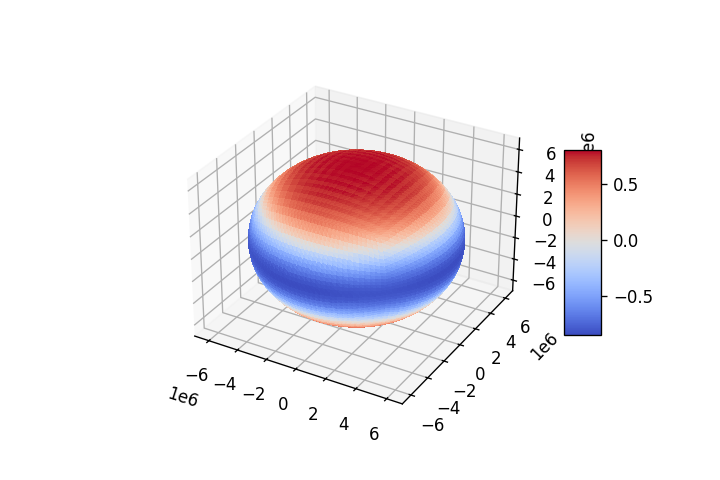

-0.8482034637963807 0.7973743078691768


In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ts = trisurf(stepper.fields('D_error'), axes=ax, cmap=cm.coolwarm)
fig.colorbar(ts, shrink=0.5, aspect=5)
plt.show()
derr = stepper.fields('D_error')
print(derr.dat.data.min(), derr.dat.data.max())

These plots show relative vorticity and depth error after 5 days, produced from a reference simulation. The setup and plotting scripts used to generate these figures were slightly different from that demonstrated in this notebook, so you should not expect to exactly reproduce these plots, but they give some idea of the final state, in particular the expected magnitude of the depth error.
![williamson_2_final](../figures/shallow_water/williamson_2_final.png)

Congratulations, you have now successfully run a Gusto example!